## New Section

In [ ]:
%%capture
try:
  already_installed
except:  
    !pip install kora
    !pip install dgl
    !pip install dgl-cu101
    !pip install --pre dgl-cu101
    !pip install dgllife
    # !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-geometric
    !pip install torch_optimizer
    #!pip install pytorch_lightning
    import sys
    import time
    import dgl
    import dgllife
    import torch 
    import pickle
    from IPython.display import clear_output
    import networkx as nx
    import dgl.function as fn
    import torch.nn.functional as F
    import torch.nn as nn
    sys.path.append('/usr/local/lib/python3.6/dist-packages/') # For using RDKit utilizing KORA
    import kora.install.rdkit
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import IPythonConsole
    from rdkit.Chem import ChemicalFeatures
    from rdkit import RDConfig
    from dgllife.utils import featurizers as fs
    from torch.utils.data import DataLoader
    import networkx as nx
    import matplotlib.pyplot as plt
    import torch_optimizer as optim
    # import pytorch_lightning as pl  
    # from pytorch_lightning.metrics.classification import AUROC
    # from pytorch_lightning.metrics.classification import AveragePrecision
    # from pytorch_lightning.metrics.classification import Recall
    # from pytorch_lightning.metrics.classification import Precision
    # from pytorch_lightning.metrics.classification import ConfusionMatrix
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import itertools
    import os
    %matplotlib inline
    import warnings
    warnings.filterwarnings("ignore")
    # Fix Seeds
    # Set a seed value
    seed_value= 213 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random 
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)
    # 5. Set `dgl` pseudo-random generator at a fixed value
    dgl.seed(seed_value)
    # 6. For layers that introduce randomness like dropout, make sure to set seed values 
    # model.add(Dropout(0.25, seed=seed_value))
    already_installed=True

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
try:
  already_installed
except:  
    !pip install kora
    !pip install dgl
    !pip install dgl-cu101
    !pip install --pre dgl-cu101
    !pip install dgllife
    # !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-geometric
    !pip install torch_optimizer
    #!pip install pytorch_lightning
    import sys
    import time
    import dgl
    import dgllife
    import torch 
    import pickle
    from IPython.display import clear_output
    import networkx as nx
    import dgl.function as fn
    import torch.nn.functional as F
    import torch.nn as nn
    sys.path.append('/usr/local/lib/python3.6/dist-packages/') # For using RDKit utilizing KORA
    import kora.install.rdkit
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import IPythonConsole
    from rdkit.Chem import ChemicalFeatures
    from rdkit import RDConfig
    from dgllife.utils import featurizers as fs
    from torch.utils.data import DataLoader
    import networkx as nx
    import matplotlib.pyplot as plt
    import torch_optimizer as optim
    # import pytorch_lightning as pl  
    # from pytorch_lightning.metrics.classification import AUROC
    # from pytorch_lightning.metrics.classification import AveragePrecision
    # from pytorch_lightning.metrics.classification import Recall
    # from pytorch_lightning.metrics.classification import Precision
    # from pytorch_lightning.metrics.classification import ConfusionMatrix
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import itertools
    import os
    %matplotlib inline
    import warnings
    warnings.filterwarnings("ignore")
    # Fix Seeds
    # Set a seed value
    seed_value= 213 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random 
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)
    # 5. Set `dgl` pseudo-random generator at a fixed value
    dgl.seed(seed_value)
    # 6. For layers that introduce randomness like dropout, make sure to set seed values 
    # model.add(Dropout(0.25, seed=seed_value))
    already_installed=True

In [ ]:
# Data Generation 

def bond_is_in_ring_list_one_hot(bond, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [bond.IsInRing()]+[bond.IsInRingSize(i) for i in list]

class CanonicalBondFeaturizer(fs.BaseBondFeaturizer):
       def __init__(self, bond_data_field='e', self_loop=False):
        super(CanonicalBondFeaturizer, self).__init__(
            featurizer_funcs={bond_data_field: fs.ConcatFeaturizer(
                [fs.bond_type_one_hot,
                 fs.bond_is_conjugated,
                 fs.bond_is_in_ring,
                 fs.bond_stereo_one_hot,
                 fs.bond_direction_one_hot,
                 bond_is_in_ring_list_one_hot
                 ]
            )}, self_loop=self_loop)
        
CanonicalBondFeaturizer = CanonicalBondFeaturizer()

# Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)

# Edge_features=[]
# no_edge=[]
# for i in range(Tox21_dataset.smiles.size):
#   try:
#     Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
#   except:
#     no_edge.append(i)
#     Edge_features.append('no_edge')

# Tox21_dataset.drop(no_edge, inplace=True)

# for i in range(len(no_edge)):
#   del Edge_features[no_edge[i]-i]

# %cd /content/

# if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF_NOH.zip'

# global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,1:].values)
# with open('Node_features_AF_NOH.pickle', 'rb') as handle:
#     Node_features = pickle.load(handle)
1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.# for i in range(len(no_edge)):
#   del Node_features[no_edge[i]-i]

# for i in range(len(no_edge)):
#   global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

class DGLDatasetTox(torch.utils.data.Dataset):

    def __init__(self):

        Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)
        
        Edge_features=[]
        no_edge=[]
        for i in range(Tox21_dataset.smiles.size):
          try:
            Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
          except:
            no_edge.append(i)
            Edge_features.append('no_edge')

        Tox21_dataset.drop(no_edge, inplace=True)

        for i in range(len(no_edge)):
          del Edge_features[no_edge[i]-i]

        %cd /content/

        if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/TOX21_Node_features_5AF_OH_Yb-solved.zip'
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
          #!unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip'

        #global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(0).iloc[:,1:].values) # 101 NaN: should be addrressed correctly
        gf_df = pd.read_csv('tox21-global-cdf-rdkit.csv')
        global_fetures = torch.Tensor(gf_df.fillna(gf_df.mean()).iloc[:,1:].values) # 101 NaN; fill mean

        #with open('Node_Features_AF3_NOH.pickle', 'rb') as handle:
        with open('TOX21_Node_features_5AF_OH_Yb-solved.pickle', 'rb') as handle:
            Node_features = pickle.load(handle)
        #Node_features[1910][1][-3] = 1.1 # problem with the atom # # with three additional features
        if torch.isnan(Node_features[1910][1][-5]) == True: # # with five additional features
          Node_features[1910][1][-5] = 1.1

        for i in range(len(no_edge)):
          del Node_features[no_edge[i]-i]

        for i in range(len(no_edge)):
          global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

        self.dgl_graphs = []
        for i in range(len(Node_features)):
          mol = Chem.MolFromSmiles(Tox21_dataset.iloc[i,-1])
          self.dgl_graphs.append(dgllife.utils.mol_to_bigraph(mol, canonical_atom_order=False))
          self.dgl_graphs[i].ndata['h_0'] = Node_features[i]
          self.dgl_graphs[i].edata['e_0'] = Edge_features[i]

        self.smiles = []
        for o in range(len(self.dgl_graphs)):
          self.smiles.append(Tox21_dataset.iloc[o,13])
          
        self.global_fetures = global_fetures
        self.labels = Tox21_dataset.iloc[:,:12].values
        self.masks = Tox21_dataset.replace({0: 1}).iloc[:,:12].values        
        
        # # Unzip the dataset and read its csv file, and fill in NaN values with 0
        # self.csv = pd.read_csv(csv_url, compression='gzip').fillna(0) 

        # # Make masks for labels (0 as NaN value, and 1 as other values)
        # self.masks_csv = pd.read_csv(csv_url, compression='gzip').replace({0: 1}).fillna(0)

        # # Split smiles, labels, and masks columns as lists
        # self.smiles = self.csv.iloc[:,13]
        # self.labels = self.csv.iloc[:,:12].values
        # self.masks = self.masks_csv.iloc[:,:12].values 

    def __len__(self):
        return len(self.dgl_graphs)

    def __getitem__(self, idx):
        return  self.smiles[idx], self.dgl_graphs[idx], self.global_fetures[idx], torch.Tensor(self.labels[idx]), torch.Tensor(self.masks[idx])
        
dataset = DGLDatasetTox()

# Train, validation, and test set split
train_set, val_set, test_set = dgllife.utils.ScaffoldSplitter.train_val_test_split(dataset, frac_val=0.1, frac_test=0.1)
#train_set, val_set, test_set = dgllife.utils.RandomSplitter.train_val_test_split(dataset, frac_val=0.1, frac_test=0.1)

def collate(batch):
    # batch is a list of triples (graphs, labels, masks)
    # Concatenate a sequence of graphs
    
    smiles = [e[0] for e in batch]
    
    graphs = [e[1] for e in batch]
    g = dgl.batch(graphs)

    gf = [e[2] for e in batch]
    gf = torch.stack(gf, 0)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[3] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (masks) along a new dimension
    masks = [e[4] for e in batch]
    masks = torch.stack(masks, 0)

    return smiles, g, gf, labels, masks

def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader

# borrowed form: https://stackoverflow.com/a/62508086
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def my_loss(output, label, mask=None):
    criterion = nn.BCELoss(reduction='none')
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
    return loss 

def train_model(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    test_aucs = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        
        with torch.no_grad():
          iter = 0
          prediction_all= torch.empty(0, device=device)
          labels_all= torch.empty(0, device=device)
          masks_all= torch.empty(0, device=device)
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              prediction_all = torch.cat((prediction_all, prediction), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, labels), 0)
          average = torch.tensor([0.], device=device)
          for i in range(12):
            #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
            average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))
          test_auc = average.item()/12
               
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'Train_Loss: {epoch_train_loss:.5f} ' +
                     f'Valid_Loss: {epoch_val_loss:.5f} ' + 
                     f'Test_AUC: {test_auc:.5f}'          
                     )
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        test_aucs.append(test_auc)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    # Draw lines
    axes[0].plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    axes[0].plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    axes[0].set_title("Learning Curve")
    axes[0].set_xlabel("Epoch"), axes[0].set_ylabel("Cross entropy loss"), axes[0].legend(loc="best")
    # Draw lines
    axes[1].plot(range(len(test_aucs)), test_aucs, color="green", label="TEST AUC")
    # Create plot
    axes[1].set_title("TEST AUC During Training")
    axes[1].set_xlabel("Epoch"), axes[1].set_ylabel("TEST AUC"), axes[1].legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) 
    print('\n Test AUC is', average.item()/12)

    return  model, train_losses, val_losses, test_aucs 

/content
Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/7812
Creating RDKit molecule instance 2000/7812
Creating RDKit molecule instance 3000/7812
Creating RDKit molecule instance 4000/7812
Creating RDKit molecule instance 5000/7812
Creating RDKit molecule instance 6000/7812
Creating RDKit molecule instance 7000/7812
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/7812
Computing Bemis-Murcko for compound 2000/7812
Computing Bemis-Murcko for compound 3000/7812
Computing Bemis-Murcko for compound 4000/7812
Computing Bemis-Murcko for compound 5000/7812
Computing Bemis-Murcko for compound 6000/7812
Computing Bemis-Murcko for compound 7000/7812


In [ ]:
%%capture
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu" 

class GGNN(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_r_dim, rep_dim, rnn_layers, hidden1_alpha_dim, hidden2_alpha_dim, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=5):
        super().__init__()
        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_r_dim = hidden_r_dim
        self.rep_dim = rep_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers 

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim)

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim)
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_r_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_r_dim)
        self.linear_r_1 = nn.Linear(self.hidden_r_dim, self.state_g_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # # It has a depth of 3
      # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
      # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
      # out = self.bn_alpha_2(self.linear_alpha_2(out))
      # out = nn.functional.relu(nn.functional.tanh(out))

      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.linear_alpha_2(out)
      out = nn.functional.relu(nn.functional.tanh(out))

      #out = nn.functional.relu(out)
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'r' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge and node states
        mol_dgl_graph.edata['e'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["e_0"])))
        mol_dgl_graph.ndata['h'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[i].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[i].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'r').view(1, len_batch,-1)),0)

          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            break
          # calculating next layer's alphas
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_rep = torch.empty(0, device=device)
          for j in range(len_batch): 
            global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

        return (hG[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) # h_rnn[-1]

In [ ]:
# checking over smoothing and alph behavior
model.eval()
au_i_std_mean = 0
nf_std_mean = 0
ef_std_mean = 0
alpha_std_mean = 0
au_i_std_mean_list = []
length = 0
_, _, test_dataloader = loader(1)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
   out = model.GNN1(mol_dgl_graph, fg)
   au_i_std_mean += torch.std(out[3], 0).mean().item()
   au_i_std_mean_list.append(torch.std(out[3], 0).mean().item())
   nf_std_mean += torch.std(out[1], 0).mean().item()
   ef_std_mean += torch.std(out[2], 0).mean().item()
   alpha_std_mean += out[-1][-1].std().item()
   length += 1
  #  if i == 0:
  #    break
print('\n',au_i_std_mean/length,'\n',alpha_std_mean/length,'\n', nf_std_mean/length,'\n',ef_std_mean/length)

_, _, test_dataloader = loader(700)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
   out = model.GNN1(mol_dgl_graph, fg)
print('\n', torch.mean(out[1],0),torch.std(out[1], 0),torch.std(out[1], 0).mean())
print('\n', torch.mean(out[2],0),torch.std(out[2], 0),torch.std(out[2], 0).mean())
print('\n', torch.mean(out[3],0),torch.std(out[3], 0),torch.std(out[3], 0).mean())
print('\n', torch.mean(out[4],0),torch.std(out[4], 0),torch.std(out[4], 0).mean())

In [ ]:
m= torch.empty(0, device=device)
s= torch.empty(0, device=device)
# model.eval()
# _, val_dataloader, _ = loader(1)
# for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
#   mol_dgl_graph=mol_dgl_graph.to(device)
#   fg= fg.to(device)
#   mean = torch.cat((mean, model.GNN1(mol_dgl_graph, fg)[-1][-1].mean()),1)
#   std = torch.cat((std, model.GNN1(mol_dgl_graph, fg)[-1][-1].std()),0)
# print(mean.mean(),std.mean())

In [ ]:
torch.cat((m,torch.Tensor([0])),0)

RuntimeError: ignored

In [ ]:
torch.cat((mean, model.GNN1(mol_dgl_graph, fg)[-1][-1].mean()),1)

In [ ]:
  mean = torch.cat((mean, model.GNN1(mol_dgl_graph, fg)[-1][-1].mean()),0)
  std = torch.cat((std, model.GNN1(mol_dgl_graph, fg)[-1][-1].std()),0)

In [ ]:
type(model.GNN1(mol_dgl_graph, fg)[-1][-1].mean())

torch.Tensor

In [ ]:
model.GNN1(mol_dgl_graph, fg)[-1][-1].mean().item()

1.0

In [ ]:
model.GNN1(mol_dgl_graph, fg)[-1][-1].std()

tensor(0., device='cuda:0', grad_fn=<StdBackward0>)

In [ ]:
model.eval()
_, val_dataloader, _ = loader(1)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
  mol_dgl_graph=mol_dgl_graph.to(device)
  fg= fg.to(device)
  break
model.GNN1(mol_dgl_graph, fg)[-1]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]], device='cuda:0', grad_fn=<CatBackward>)

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=2)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=10)
# count_parameters(model)

[ 29/200] Train_Loss: 0.09505 Valid_Loss: 0.48163 Test_AUC: 0.49741
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 4154.8189470767975 seconds in cpu




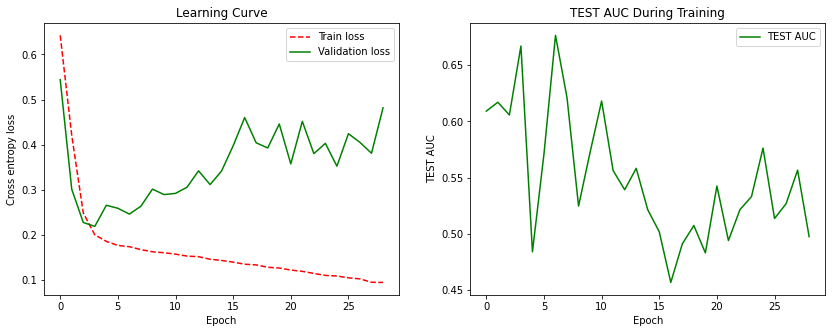


 Test AUC is 0.6670538584391276


ValueError: ignored

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=3)
        self.linear_1 = nn.Linear(200, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
model.eval()
_, val_dataloader, _ = loader(1)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
  mol_dgl_graph=mol_dgl_graph.to(device)
  fg= fg.to(device)
  break
model.GNN1(mol_dgl_graph, fg)[-1]

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.8080, 0.7872, 0.7704, 0.7915, 0.7838, 0.7749, 0.7762, 0.8270, 0.7812,
         0.7951, 0.7886, 0.7931, 0.7903, 0.7910, 0.8375, 0.7984, 0.8034, 0.8251,
         0.8034, 0.8251, 0.8041, 0.7780, 0.8008, 0.8371],
        [0.8943, 0.8905, 0.8942, 0.8964, 0.8883, 0.8868, 0.8792, 0.8852, 0.8871,
         0.8882, 0.8787, 0.8845, 0.8833, 0.8790, 0.8768, 0.8867, 0.8859, 0.8758,
         0.8859, 0.8758, 0.8931, 0.8926, 0.8879, 0.8768],
        [0.6514, 0.5560, 0.6101, 0.6464, 0.6329, 0.5774, 0.5045, 0.6251, 0.6353,
         0.6860, 0.6617, 0.6795, 0.7014, 0.6577, 0.7608, 0.7060, 0.5713, 0.7304,
         0.5713, 0.7304, 0.6815, 0.6888, 0.6945, 0.7630]], device='cuda:0',
       grad_fn=<CatBackward>)

[ 32/200] Train_Loss: 0.09641 Valid_Loss: 0.21358 Test_AUC: 0.77958
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 486.94362449645996 seconds in cuda:0




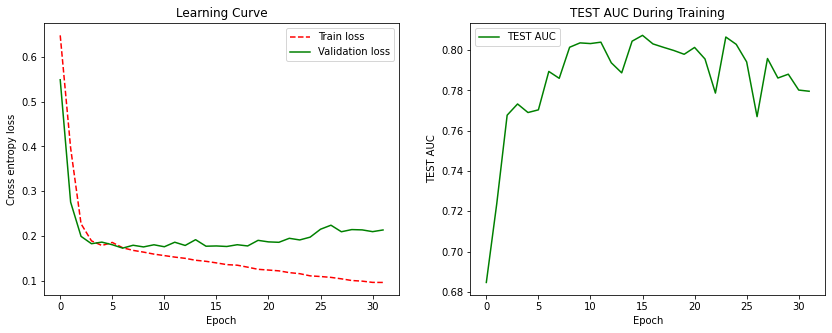


 Test AUC is 0.7894161542256674
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2824814

In [ ]:
# 163, Scafold
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 40/200] Train_Loss: 0.07330 Valid_Loss: 0.26398 Test_AUC: 0.76094
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 599.5418856143951 seconds in cuda:0




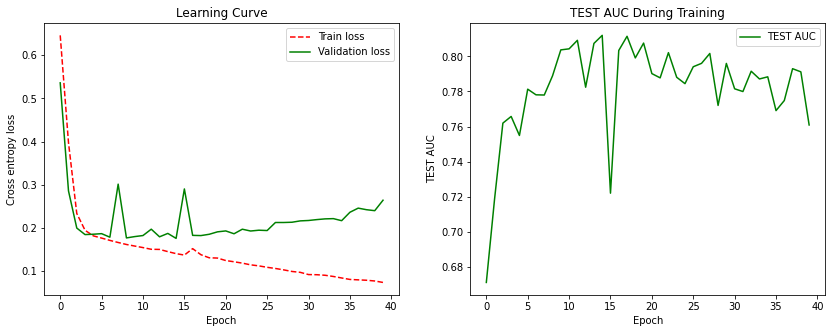


 Test AUC is 0.811974843343099
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |


2824814

In [ ]:
# 163, Scafold
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
# 163, Scafold
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 23/200] Train_Loss: 0.11843 Valid_Loss: 0.19203 Test_AUC: 0.78696
EarlyStopping counter: 11 out of 25


[ 38/200] Train_Loss: 0.07523 Valid_Loss: 0.22765 Test_AUC: 0.77236
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1028.187691450119 seconds in cuda:0




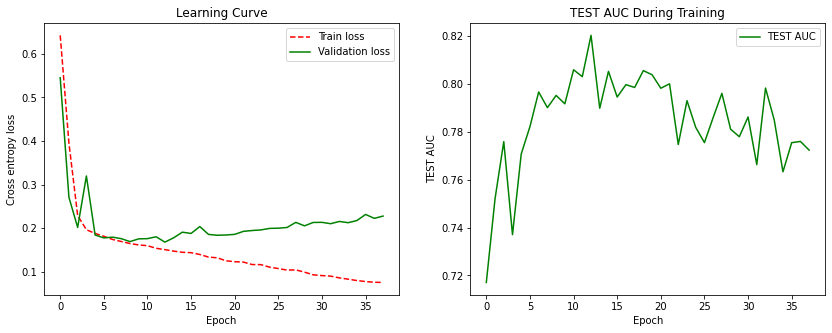


 Test AUC is 0.8203264077504476
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    8700    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2784614

In [ ]:
# random split
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 35/200] Train_Loss: 0.07056 Valid_Loss: 0.22290 Test_AUC: 0.77653
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 941.5462160110474 seconds in cuda:0




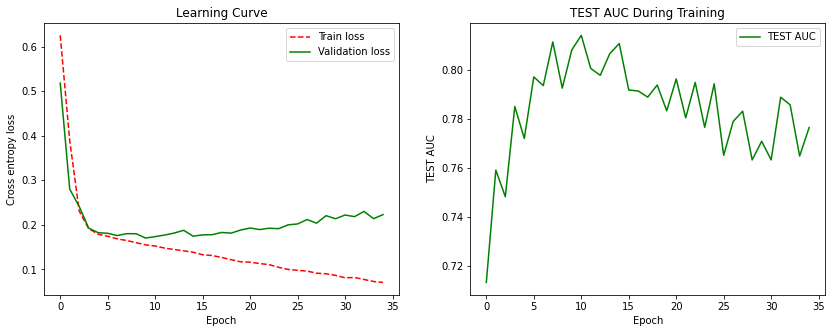


 Test AUC is 0.8082370758056641
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    8700    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2784614

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 40/200] Train_Loss: 0.06584 Valid_Loss: 0.23489 Test_AUC: 0.76975
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1064.1774995326996 seconds in cuda:0




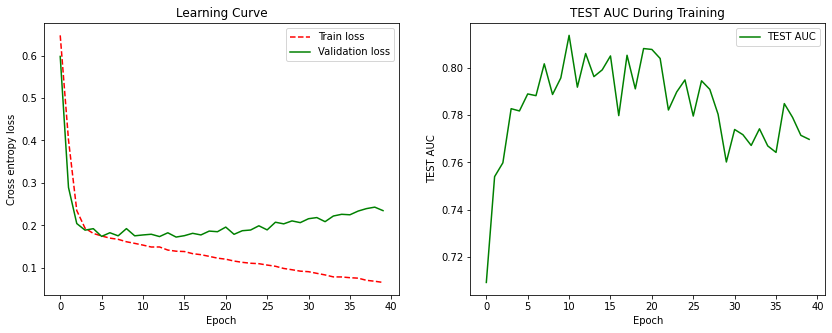


 Test AUC is 0.7991508642832438
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    8700    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2784614

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 38/200] Train_Loss: 0.07212 Valid_Loss: 0.24557 Test_AUC: 0.79591
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 557.4343907833099 seconds in cuda:0




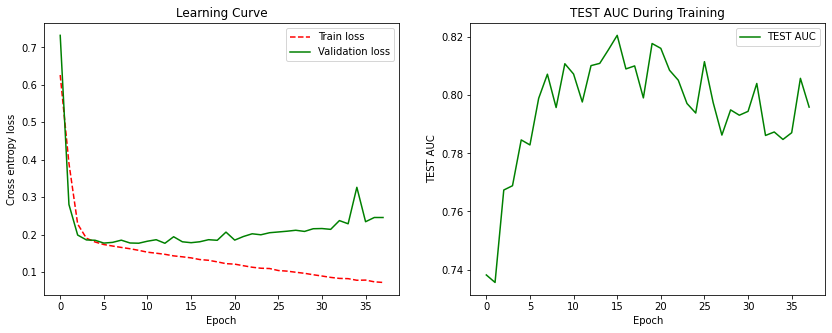


 Test AUC is 0.8101843992869059


ValueError: ignored

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 34/200] Train_Loss: 0.07779 Valid_Loss: 0.24009 Test_AUC: 0.77811
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 948.1906962394714 seconds in cuda:0




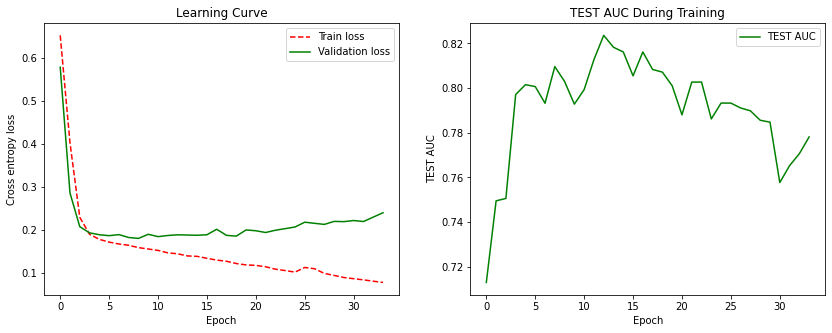


 Test AUC is 0.8029437859853109
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    8700    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2784614

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 36/200] Train_Loss: 0.14241 Valid_Loss: 0.22492 Test_AUC: 0.79451
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1035.9320905208588 seconds in cuda:0




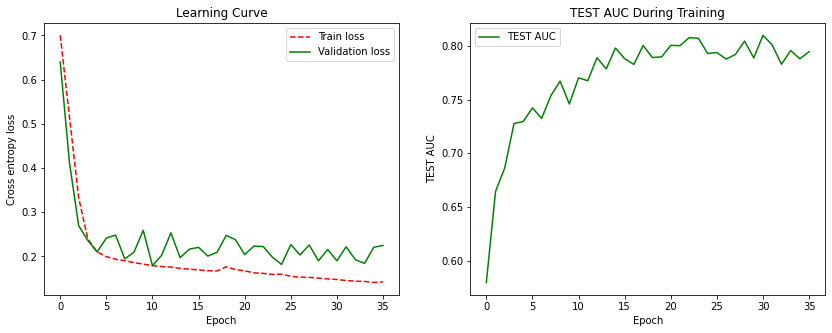


 Test AUC is 0.7701385021209717
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    5800    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |

1533236

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN2 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.GNN3 = GGNN(100,100,100,50,50,50,50,50,50,50,50,50,1,50,50,num_layers=1)
        self.GNN4 = GGNN(50,50,50,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=1)
        self.linear_1 = nn.Linear(30, 20)
        self.linear_2 = nn.Linear(20, 12)
        #self.bn = nn.BatchNorm1d(50)
        self.bn1 = nn.BatchNorm1d(20)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN3(mol_dgl_graph,fg)
      output = self.GNN4(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 42/200] Train_Loss: 0.14743 Valid_Loss: 0.18451 Test_AUC: 0.77843
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 607.3034789562225 seconds in cuda:0




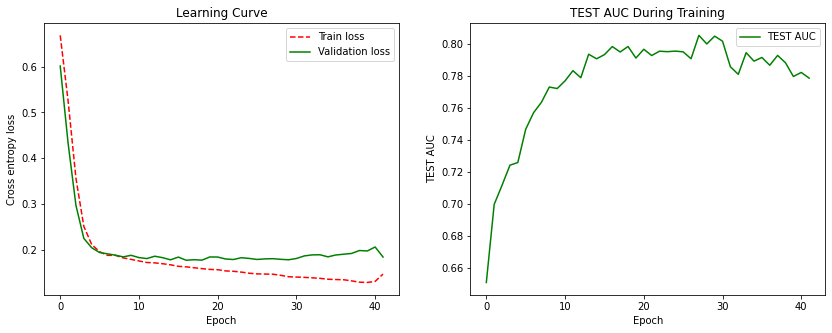


 Test AUC is 0.7981122334798177
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    1160    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    9600    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

67199

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.GNN2 = GGNN(40,40,40,20,20,20,20,20,20,20,20,20,1,20,20,num_layers=1)
        self.linear_1 = nn.Linear(20, 15)
        self.linear_2 = nn.Linear(15, 12)
        #self.bn = nn.BatchNorm1d(50)
        self.bn1 = nn.BatchNorm1d(15)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 33/200] Train_Loss: 0.07658 Valid_Loss: 0.23633 Test_AUC: 0.77895
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 478.9545283317566 seconds in cuda:0




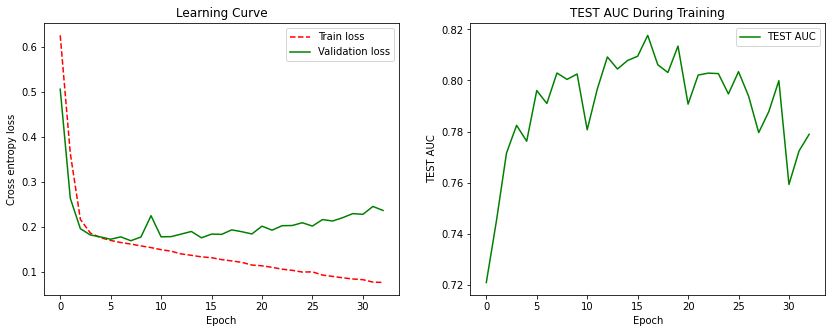


 Test AUC is 0.8029130299886068
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   11600    |
|    GNN1.linear_0_v.bias    |    400     |
|     GNN1.bn_0_v.weight     |    400     |
|      GNN1.bn_0_v.bias      |    400     |
|   GNN1.linear_0_e.weight   |    7600    |
|    GNN1.linear_0_e.bias    |    400     |
|     GNN1.bn_0_e.weight     |    400     |
|      GNN1.bn_0_e.bias      |    400     |
|   GNN1.linear_0_g.weight   |   80000    |
|    GNN1.linear_0_g.bias    |    400     |
|     GNN1.bn_0_g.weight     |    400     |
|      GNN1.bn_0_g.bias      |    400     |
|   GNN1.linear_e_0.weight   |   960000   |
|    GNN1.linear_e_0.bias    |    400     |
|     GNN1.bn_e_0.weight     |    400     |
|      GNN1.bn_e_0.bias      |    400     |
|   GNN1.linear_e_1.weight   |   160000   |
|    GNN1.linear_e_1.bias    |    400     |
|     GNN1.bn_e_1.weight     |    400     |

5573364

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,400,400,400,400,400,400,400,400,400,1,400,400,num_layers=1)
        self.GNN2 = GGNN(400,400,400,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(50)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
test_aucs

[0.7210253874460856,
 0.7450478871663412,
 0.7716062863667806,
 0.7824486891428629,
 0.7762463092803955,
 0.7960536479949951,
 0.7910010814666748,
 0.8029130299886068,
 0.8004232247670492,
 0.8025192419687907,
 0.7807177702585856,
 0.796626091003418,
 0.8091949621836344,
 0.8044711748758951,
 0.8078155517578125,
 0.8094683488210043,
 0.8176407814025879,
 0.806131919225057,
 0.8031089305877686,
 0.8134421507517496,
 0.7907436688741049,
 0.8021157582600912,
 0.8028746445973715,
 0.8026874860127767,
 0.7947407563527426,
 0.8034491539001465,
 0.7938582102457682,
 0.7796208063761393,
 0.7878034114837646,
 0.799914280573527,
 0.7593442598978678,
 0.772442897160848,
 0.7789503733317057]

[ 35/200] Train_Loss: 0.08069 Valid_Loss: 0.22436 Test_AUC: 0.77398
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 518.2904336452484 seconds in cuda:0




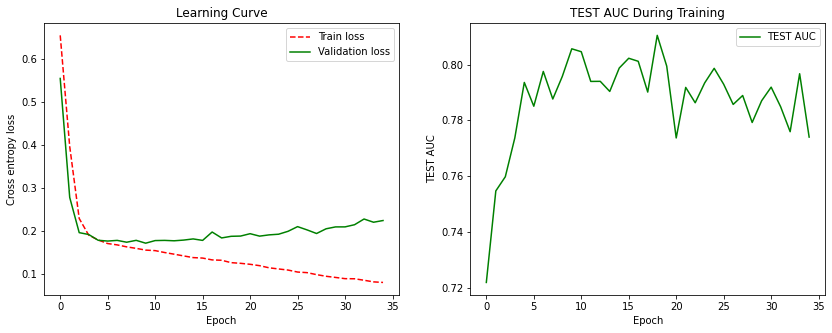


 Test AUC is 0.8056384722391764
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    8700    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2784614

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 40/200] Train_Loss: 0.17878 Valid_Loss: 0.24990 Test_AUC: 0.62296
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1091.727281332016 seconds in cuda:0




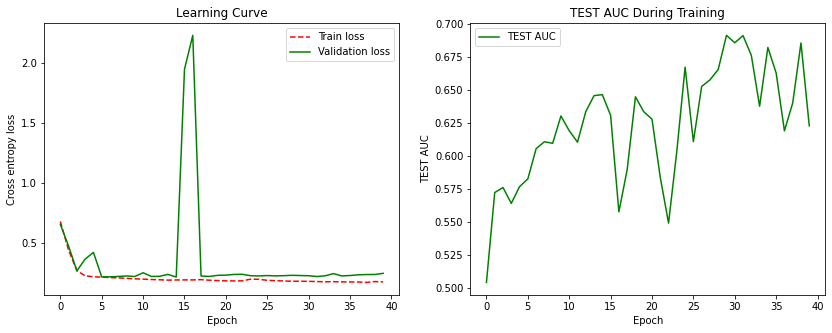


 Test AUC is 0.6465998888015747
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    4350    |
|    GNN1.linear_0_v.bias    |    150     |
|     GNN1.bn_0_v.weight     |    150     |
|      GNN1.bn_0_v.bias      |    150     |
|   GNN1.linear_0_e.weight   |    2850    |
|    GNN1.linear_0_e.bias    |    150     |
|     GNN1.bn_0_e.weight     |    150     |
|      GNN1.bn_0_e.bias      |    150     |
|   GNN1.linear_0_g.weight   |   30000    |
|    GNN1.linear_0_g.bias    |    150     |
|     GNN1.bn_0_g.weight     |    150     |
|      GNN1.bn_0_g.bias      |    150     |
|   GNN1.linear_e_0.weight   |   135000   |
|    GNN1.linear_e_0.bias    |    150     |
|     GNN1.bn_e_0.weight     |    150     |
|      GNN1.bn_e_0.bias      |    150     |
|   GNN1.linear_e_1.weight   |   22500    |
|    GNN1.linear_e_1.bias    |    150     |
|     GNN1.bn_e_1.weight     |    150     |

719464

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,150,150,150,150,150,150,150,150,150,1,150,150,num_layers=3)
        self.GNN2 = GGNN(150,150,150,50,50,50,50,50,50,50,50,50,1,50,50,num_layers=3)
        self.linear_1 = nn.Linear(50, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 34/200] Train_Loss: 0.10032 Valid_Loss: 0.20689 Test_AUC: 0.78596
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 497.4784803390503 seconds in cuda:0




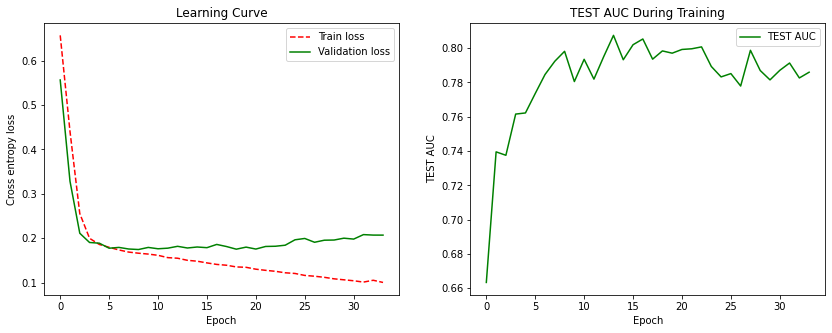


 Test AUC is 0.7981422742207845
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    4350    |
|    GNN1.linear_0_v.bias    |    150     |
|     GNN1.bn_0_v.weight     |    150     |
|      GNN1.bn_0_v.bias      |    150     |
|   GNN1.linear_0_e.weight   |    2850    |
|    GNN1.linear_0_e.bias    |    150     |
|     GNN1.bn_0_e.weight     |    150     |
|      GNN1.bn_0_e.bias      |    150     |
|   GNN1.linear_0_g.weight   |   30000    |
|    GNN1.linear_0_g.bias    |    150     |
|     GNN1.bn_0_g.weight     |    150     |
|      GNN1.bn_0_g.bias      |    150     |
|   GNN1.linear_e_0.weight   |   135000   |
|    GNN1.linear_e_0.bias    |    150     |
|     GNN1.bn_e_0.weight     |    150     |
|      GNN1.bn_e_0.bias      |    150     |
|   GNN1.linear_e_1.weight   |   22500    |
|    GNN1.linear_e_1.bias    |    150     |
|     GNN1.bn_e_1.weight     |    150     |

719464

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,150,150,150,150,150,150,150,150,150,1,150,150,num_layers=1)
        self.GNN2 = GGNN(150,150,150,50,50,50,50,50,50,50,50,50,1,50,50,num_layers=1)
        self.linear_1 = nn.Linear(50, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 39/200] Train_Loss: 0.09613 Valid_Loss: 0.21082 Test_AUC: 0.79053
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 573.0782833099365 seconds in cuda:0




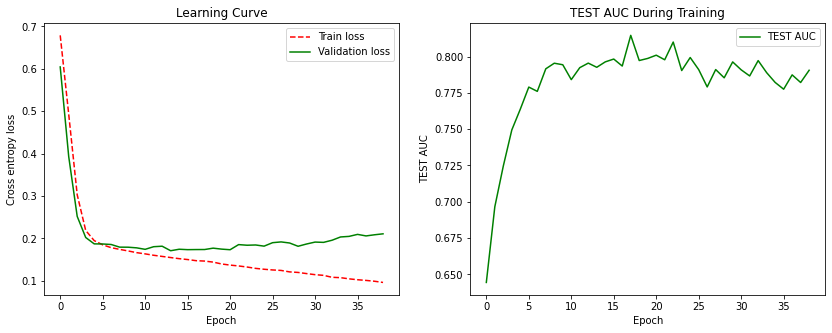


 Test AUC is 0.7925748030344645
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    2900    |
|    GNN1.linear_0_v.bias    |    100     |
|     GNN1.bn_0_v.weight     |    100     |
|      GNN1.bn_0_v.bias      |    100     |
|   GNN1.linear_0_e.weight   |    1900    |
|    GNN1.linear_0_e.bias    |    100     |
|     GNN1.bn_0_e.weight     |    100     |
|      GNN1.bn_0_e.bias      |    100     |
|   GNN1.linear_0_g.weight   |   20000    |
|    GNN1.linear_0_g.bias    |    100     |
|     GNN1.bn_0_g.weight     |    100     |
|      GNN1.bn_0_g.bias      |    100     |
|   GNN1.linear_e_0.weight   |   60000    |
|    GNN1.linear_e_0.bias    |    100     |
|     GNN1.bn_e_0.weight     |    100     |
|      GNN1.bn_e_0.bias      |    100     |
|   GNN1.linear_e_1.weight   |   10000    |
|    GNN1.linear_e_1.bias    |    100     |
|     GNN1.bn_e_1.weight     |    100     |

344974

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.GNN2 = GGNN(100,100,100,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(20)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 47/200] Train_Loss: 0.08113 Valid_Loss: 0.22550 Test_AUC: 0.78839
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1012.7981762886047 seconds in cuda:0




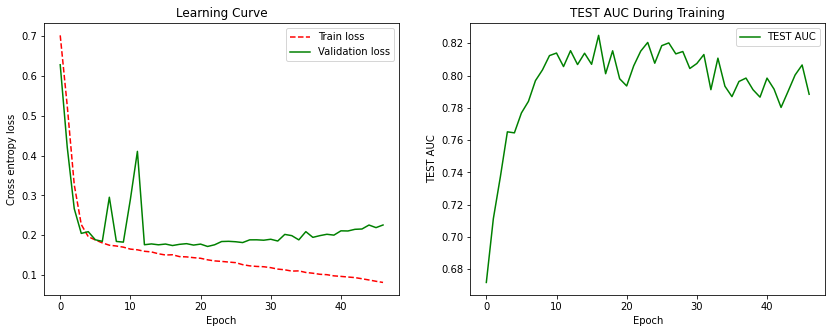


 Test AUC is 0.805977980295817
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    5800    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |


1477575

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN2 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.GNN3 = GGNN(100,100,100,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(20)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph,fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 43/200] Train_Loss: 0.07374 Valid_Loss: 0.23689 Test_AUC: 0.76532
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 635.811282157898 seconds in cuda:0




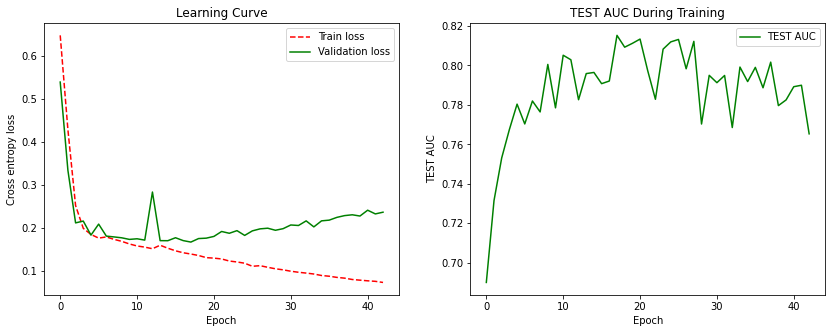


 Test AUC is 0.8152149518330892
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    5800    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |

1424764

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN2 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 35/200] Train_Loss: 0.06558 Valid_Loss: 0.24166 Test_AUC: 0.78376
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 266.34390664100647 seconds in cuda:0




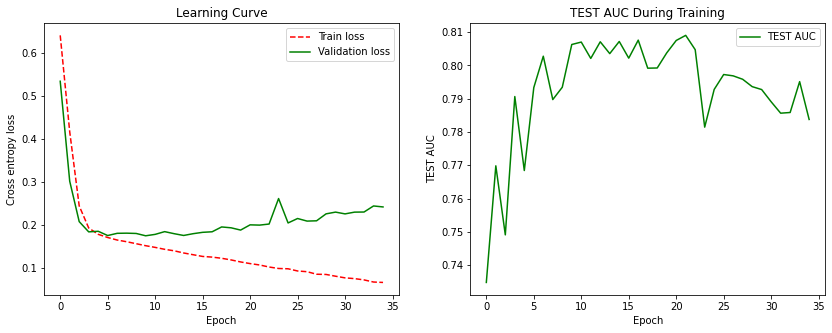


 Test AUC is 0.8062822818756104
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    5800    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |

1103863

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 35/200] Train_Loss: 0.07521 Valid_Loss: 0.24540 Test_AUC: 0.79469
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 265.40768814086914 seconds in cuda:0




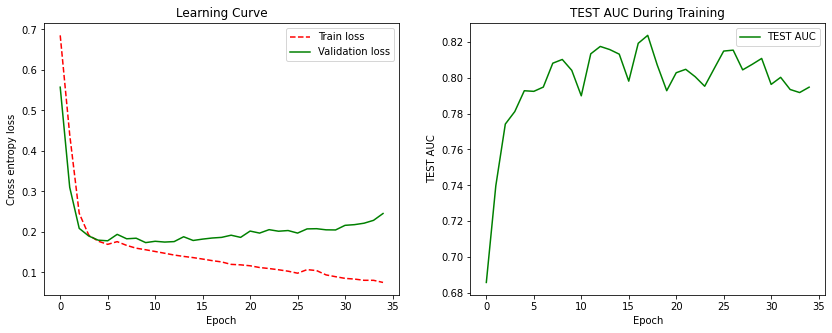


 Test AUC is 0.8040596644083658
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    5800    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |

1103863

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 32/200] Train_Loss: 0.07839 Valid_Loss: 0.22517 Test_AUC: 0.79071
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 241.83436799049377 seconds in cuda:0




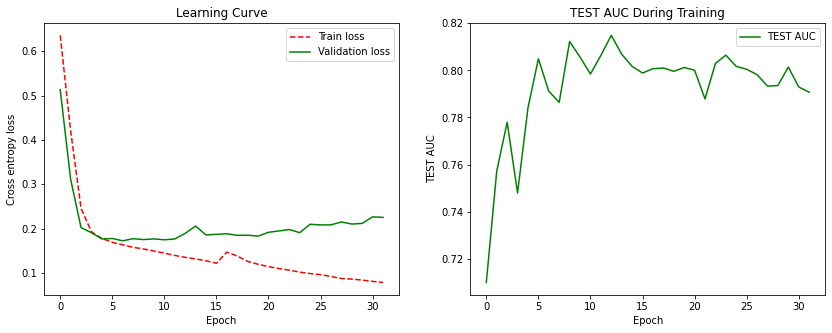


 Test AUC is 0.7911190986633301
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    5800    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |

1103863

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 45/200] Train_Loss: 0.10859 Valid_Loss: 0.19603 Test_AUC: 0.79080
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 337.47520899772644 seconds in cuda:0




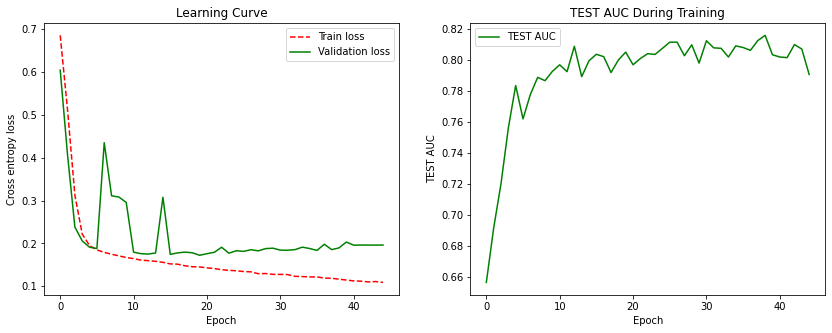


 Test AUC is 0.8052481810251871
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    1160    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    9600    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

54193

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 46/200] Train_Loss: 0.10645 Valid_Loss: 0.20735 Test_AUC: 0.78339
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 345.4166657924652 seconds in cuda:0




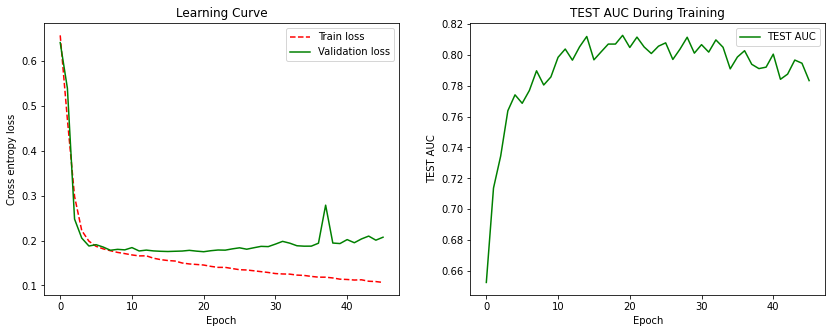


 Test AUC is 0.804879347483317
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    1160    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    9600    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |


54193

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 34/200] Train_Loss: 0.07107 Valid_Loss: 0.25096 Test_AUC: 0.78665
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 265.1429603099823 seconds in cuda:0




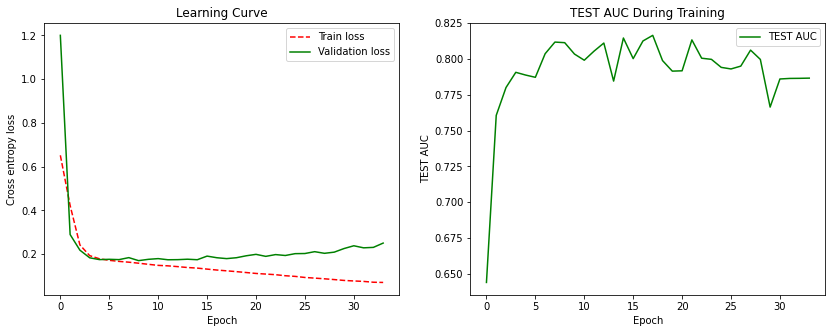


 Test AUC is 0.8114209175109863
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    5800    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |

1103863

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 34/200] train_loss: 0.04183 valid_loss: 0.27726
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 272.1812734603882 seconds in cuda:0




<Figure size 504x360 with 0 Axes>

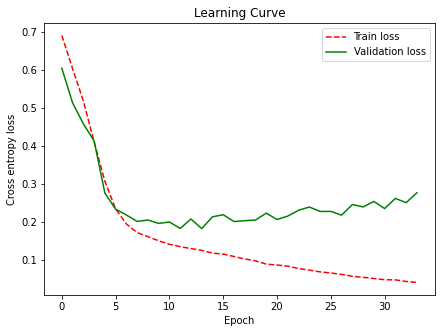


 Test AUC is 0.7857645352681478
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   11600    |
|    GNN1.linear_0_v.bias    |    400     |
|     GNN1.bn_0_v.weight     |    400     |
|      GNN1.bn_0_v.bias      |    400     |
|   GNN1.linear_0_e.weight   |    7600    |
|    GNN1.linear_0_e.bias    |    400     |
|     GNN1.bn_0_e.weight     |    400     |
|      GNN1.bn_0_e.bias      |    400     |
|   GNN1.linear_0_g.weight   |   80000    |
|    GNN1.linear_0_g.bias    |    400     |
|     GNN1.bn_0_g.weight     |    400     |
|      GNN1.bn_0_g.bias      |    400     |
|   GNN1.linear_e_0.weight   |   960000   |
|    GNN1.linear_e_0.bias    |    400     |
|     GNN1.bn_e_0.weight     |    400     |
|      GNN1.bn_e_0.bias      |    400     |
|   GNN1.linear_e_1.weight   |   160000   |
|    GNN1.linear_e_1.bias    |    400     |
|     GNN1.bn_e_1.weight     |    400     |

4316313

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,400,400,400,400,400,400,400,400,400,1,400,400,num_layers=1)
        self.linear_1 = nn.Linear(400, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=256, optimizer=optimizer, patience=20, n_epochs=200)
count_parameters(model)

[ 32/200] train_loss: 0.05743 valid_loss: 0.26374
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 229.49639248847961 seconds in cuda:0




<Figure size 504x360 with 0 Axes>

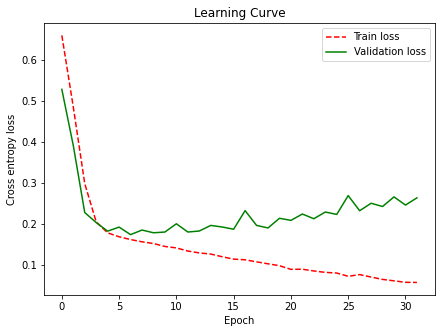


 Test AUC is 0.8071707089742025
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   11600    |
|    GNN1.linear_0_v.bias    |    400     |
|     GNN1.bn_0_v.weight     |    400     |
|      GNN1.bn_0_v.bias      |    400     |
|   GNN1.linear_0_e.weight   |    7600    |
|    GNN1.linear_0_e.bias    |    400     |
|     GNN1.bn_0_e.weight     |    400     |
|      GNN1.bn_0_e.bias      |    400     |
|   GNN1.linear_0_g.weight   |   80000    |
|    GNN1.linear_0_g.bias    |    400     |
|     GNN1.bn_0_g.weight     |    400     |
|      GNN1.bn_0_g.bias      |    400     |
|   GNN1.linear_e_0.weight   |   960000   |
|    GNN1.linear_e_0.bias    |    400     |
|     GNN1.bn_e_0.weight     |    400     |
|      GNN1.bn_e_0.bias      |    400     |
|   GNN1.linear_e_1.weight   |   160000   |
|    GNN1.linear_e_1.bias    |    400     |
|     GNN1.bn_e_1.weight     |    400     |

4316313

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,400,400,400,400,400,400,400,400,400,1,400,400,num_layers=1)
        self.linear_1 = nn.Linear(400, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=128, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 32/200] train_loss: 0.05496 valid_loss: 0.26965
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 226.0028314590454 seconds in cuda:0




<Figure size 504x360 with 0 Axes>

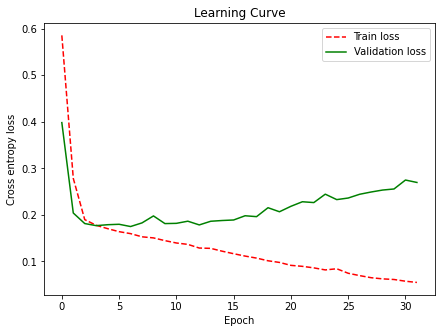


 Test AUC is 0.7917364438374838
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   11600    |
|    GNN1.linear_0_v.bias    |    400     |
|     GNN1.bn_0_v.weight     |    400     |
|      GNN1.bn_0_v.bias      |    400     |
|   GNN1.linear_0_e.weight   |    7600    |
|    GNN1.linear_0_e.bias    |    400     |
|     GNN1.bn_0_e.weight     |    400     |
|      GNN1.bn_0_e.bias      |    400     |
|   GNN1.linear_0_g.weight   |   80000    |
|    GNN1.linear_0_g.bias    |    400     |
|     GNN1.bn_0_g.weight     |    400     |
|      GNN1.bn_0_g.bias      |    400     |
|   GNN1.linear_e_0.weight   |   960000   |
|    GNN1.linear_e_0.bias    |    400     |
|     GNN1.bn_e_0.weight     |    400     |
|      GNN1.bn_e_0.bias      |    400     |
|   GNN1.linear_e_1.weight   |   160000   |
|    GNN1.linear_e_1.bias    |    400     |
|     GNN1.bn_e_1.weight     |    400     |

4316313

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,400,400,400,400,400,400,400,400,400,1,400,400,num_layers=1)
        self.linear_1 = nn.Linear(400, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 33/200] train_loss: 0.05290 valid_loss: 0.26870
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 228.60712575912476 seconds in cuda:0




<Figure size 504x360 with 0 Axes>

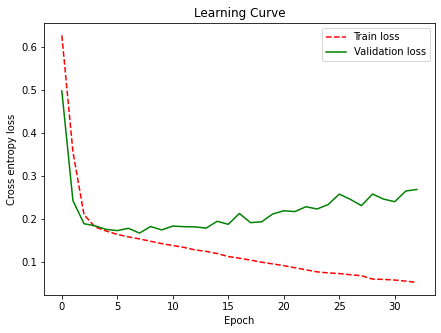


 Test AUC is 0.8037104606628418
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    8700    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2441863

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.linear_1 = nn.Linear(300, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 39/200] train_loss: 0.04994 valid_loss: 0.27418
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 273.91274189949036 seconds in cuda:0




<Figure size 504x360 with 0 Axes>

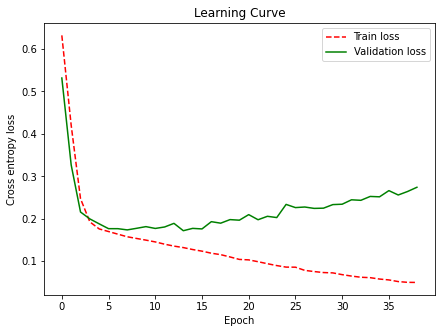


 Test AUC is 0.8023825486501058
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    5800    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |

1103863

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 42/200] train_loss: 0.11359 valid_loss: 0.19688
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 291.0856728553772 seconds in cuda:0




<Figure size 504x360 with 0 Axes>

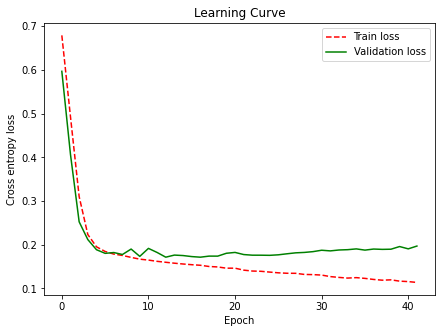


 Test AUC is 0.8119098345438639
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    1160    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    9600    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

54193

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 33/200] train_loss: 0.11938 valid_loss: 0.19271
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 414.30215215682983 seconds in cpu




<Figure size 504x360 with 0 Axes>

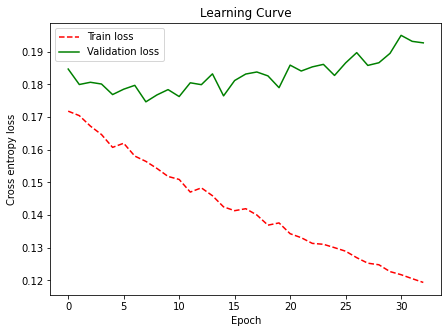


 Test AUC is 0.8108962376912435
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    1160    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    9600    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

54193

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 28/200] train_loss: 0.07633 valid_loss: 0.24134
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 887.7913928031921 seconds in cpu




<Figure size 504x360 with 0 Axes>

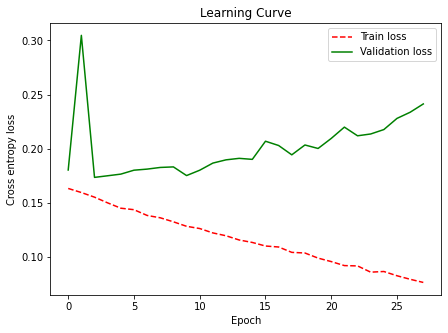


 Test AUC is 0.8051844437917074
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    2900    |
|    GNN1.linear_0_v.bias    |    100     |
|     GNN1.bn_0_v.weight     |    100     |
|      GNN1.bn_0_v.bias      |    100     |
|   GNN1.linear_0_e.weight   |    1900    |
|    GNN1.linear_0_e.bias    |    100     |
|     GNN1.bn_0_e.weight     |    100     |
|      GNN1.bn_0_e.bias      |    100     |
|   GNN1.linear_0_g.weight   |   20000    |
|    GNN1.linear_0_g.bias    |    100     |
|     GNN1.bn_0_g.weight     |    100     |
|      GNN1.bn_0_g.bias      |    100     |
|   GNN1.linear_e_0.weight   |   60000    |
|    GNN1.linear_e_0.bias    |    100     |
|     GNN1.bn_e_0.weight     |    100     |
|      GNN1.bn_e_0.bias      |    100     |
|   GNN1.linear_e_1.weight   |   10000    |
|    GNN1.linear_e_1.bias    |    100     |
|     GNN1.bn_e_1.weight     |    100     |

292163

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 33/200] train_loss: 0.10340 valid_loss: 0.20745
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 509.77764797210693 seconds in cpu




<Figure size 504x360 with 0 Axes>

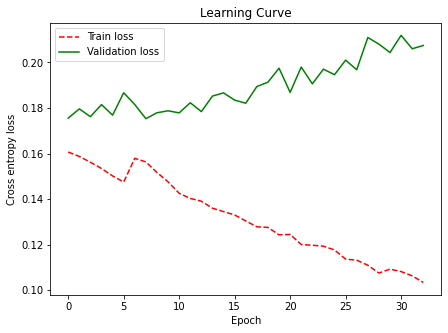


 Test AUC is 0.801288366317749
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    1450    |
|    GNN1.linear_0_v.bias    |     50     |
|     GNN1.bn_0_v.weight     |     50     |
|      GNN1.bn_0_v.bias      |     50     |
|   GNN1.linear_0_e.weight   |    950     |
|    GNN1.linear_0_e.bias    |     50     |
|     GNN1.bn_0_e.weight     |     50     |
|      GNN1.bn_0_e.bias      |     50     |
|   GNN1.linear_0_g.weight   |   10000    |
|    GNN1.linear_0_g.bias    |     50     |
|     GNN1.bn_0_g.weight     |     50     |
|      GNN1.bn_0_g.bias      |     50     |
|   GNN1.linear_e_0.weight   |   15000    |
|    GNN1.linear_e_0.bias    |     50     |
|     GNN1.bn_e_0.weight     |     50     |
|      GNN1.bn_e_0.bias      |     50     |
|   GNN1.linear_e_1.weight   |    2500    |
|    GNN1.linear_e_1.bias    |     50     |
|     GNN1.bn_e_1.weight     |     50     |


81313

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,50,50,50,50,50,50,50,50,50,1,50,50,num_layers=1)
        self.linear_1 = nn.Linear(50, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 63/200] train_loss: 0.10730 valid_loss: 0.19854
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 974.7890450954437 seconds in cpu




<Figure size 504x360 with 0 Axes>

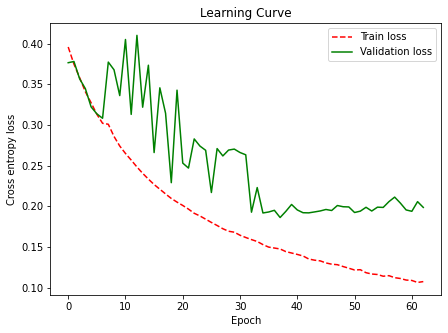


 Test AUC is 0.7842019399007162
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    1450    |
|    GNN1.linear_0_v.bias    |     50     |
|     GNN1.bn_0_v.weight     |     50     |
|      GNN1.bn_0_v.bias      |     50     |
|   GNN1.linear_0_e.weight   |    950     |
|    GNN1.linear_0_e.bias    |     50     |
|     GNN1.bn_0_e.weight     |     50     |
|      GNN1.bn_0_e.bias      |     50     |
|   GNN1.linear_0_g.weight   |   10000    |
|    GNN1.linear_0_g.bias    |     50     |
|     GNN1.bn_0_g.weight     |     50     |
|      GNN1.bn_0_g.bias      |     50     |
|   GNN1.linear_e_0.weight   |   15000    |
|    GNN1.linear_e_0.bias    |     50     |
|     GNN1.bn_e_0.weight     |     50     |
|      GNN1.bn_e_0.bias      |     50     |
|   GNN1.linear_e_1.weight   |    2500    |
|    GNN1.linear_e_1.bias    |     50     |
|     GNN1.bn_e_1.weight     |     50     |

81337

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,50,50,50,50,50,50,50,50,50,1,50,50,num_layers=1)
        self.linear_1 = nn.Linear(50, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.bn2(self.linear_2(output)))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 40/200] train_loss: 0.13083 valid_loss: 0.19486
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 488.6819565296173 seconds in cpu




<Figure size 504x360 with 0 Axes>

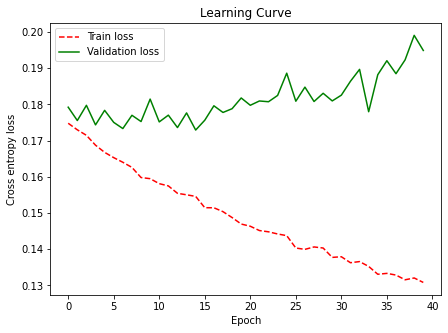


 Test AUC is 0.8005657196044922
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|     GNN1.bn_0_v.weight     |     30     |
|      GNN1.bn_0_v.bias      |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|     GNN1.bn_0_e.weight     |     30     |
|      GNN1.bn_0_e.bias      |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|     GNN1.bn_0_g.weight     |     30     |
|      GNN1.bn_0_g.bias      |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|     GNN1.bn_e_0.weight     |     30     |
|      GNN1.bn_e_0.bias      |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|     GNN1.bn_e_1.weight     |     30     |

32698

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=1)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.bn = nn.BatchNorm1d(15)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 30/200] train_loss: 0.15810 valid_loss: 0.27247
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 911.8309791088104 seconds in cpu




<Figure size 504x360 with 0 Axes>

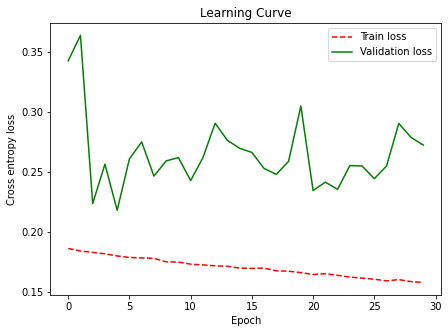


 Test AUC is 0.6860270500183105
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|     GNN1.bn_0_v.weight     |     30     |
|      GNN1.bn_0_v.bias      |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|     GNN1.bn_0_e.weight     |     30     |
|      GNN1.bn_0_e.bias      |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|     GNN1.bn_0_g.weight     |     30     |
|      GNN1.bn_0_g.bias      |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|     GNN1.bn_e_0.weight     |     30     |
|      GNN1.bn_e_0.bias      |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|     GNN1.bn_e_1.weight     |     30     |

32698

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=3)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.bn = nn.BatchNorm1d(15)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
model.eval()
train_dataloader, val_dataloader, test_dataloader  = loader(1)
for i, (smiles, mol_dgl_graph, globalss, labels, masks) in enumerate(train_dataloader):
  if i == 1:
    break
i = model.GNN1(mol_dgl_graph.to(device), globalss.to(device))
i[2]

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.8175, 0.9221, 0.9153, 0.8262, 0.8925, 0.8925, 0.9221, 0.8175, 0.9153,
         0.8262],
        [0.7694, 0.8368, 0.8500, 0.7872, 0.8221, 0.8221, 0.8368, 0.7694, 0.8500,
         0.7872],
        [0.8069, 0.8606, 0.8597, 0.8135, 0.8455, 0.8455, 0.8606, 0.8069, 0.8597,
         0.8135],
        [0.7827, 0.8621, 0.8581, 0.7930, 0.8435, 0.8435, 0.8621, 0.7827, 0.8581,
         0.7930],
        [0.7879, 0.8564, 0.8547, 0.7948, 0.8347, 0.8347, 0.8564, 0.7879, 0.8547,
         0.7948],
        [0.7691, 0.8431, 0.8428, 0.7757, 0.8134, 0.8134, 0.8431, 0.7691, 0.8428,
         0.7757],
        [0.7968, 0.8350, 0.8356, 0.7994, 0.8269, 0.8269, 0.8350, 0.7968, 0.8356,
         0.7994],
        [0.7789, 0.8392, 0.8387, 0.7797, 0.8229, 0.8229, 0.8392, 0.7789, 0.8387,
         0.7797],
        [0.8158, 0.8607, 0.8610, 0.8161, 0.8477, 0.8477, 0.8607, 0.8158, 0.8610,
         0.8161],
        [0

In [ ]:
mean = torch.empty(0, device=device)
train_dataloader, val_dataloader, test_dataloader  = loader(1000)
model.eval()
for i, (smiles, mol_dgl_graph, globalss, labels, masks) in enumerate(train_dataloader):
  out = model.GNN1(mol_dgl_graph.to(device), globalss.to(device))  
  mean = torch.cat((mean, out[0].view(-1,30)),0)
print(mean.shape)
mean = torch.mean(mean, 0)
print(mean.shape)
mean


torch.Size([6249, 30])
torch.Size([30])


tensor([3.6566, 5.3643, 4.6321, 2.0346, 8.3493, 7.5461, 3.9111, 8.8468, 2.1133,
        3.5300, 5.2283, 7.3067, 5.0844, 4.8784, 4.1819, 5.9363, 1.4308, 4.2865,
        1.3070, 3.2763, 3.8372, 2.6591, 3.4094, 1.9183, 4.4602, 3.8729, 3.0684,
        3.5568, 7.4337, 4.0343], grad_fn=<MeanBackward1>)

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=10)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.bn = nn.BatchNorm1d(15)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 3/10] train_loss: 0.22801 valid_loss: 0.49556
Validation loss decreased (0.501798 --> 0.495561).  Saving model ...


KeyboardInterrupt: ignored

[ 27/200] train_loss: 0.15960 valid_loss: 0.28221
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 787.7603118419647 seconds in cpu




<Figure size 504x360 with 0 Axes>

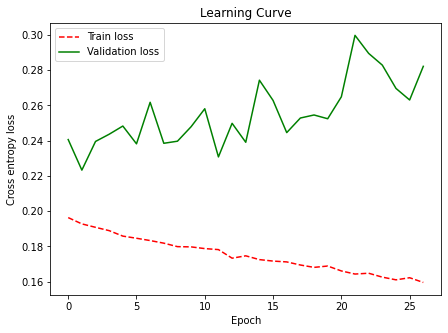


 Test AUC is 0.7094202041625977
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|     GNN1.bn_0_v.weight     |     30     |
|      GNN1.bn_0_v.bias      |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|     GNN1.bn_0_e.weight     |     30     |
|      GNN1.bn_0_e.bias      |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|     GNN1.bn_0_g.weight     |     30     |
|      GNN1.bn_0_g.bias      |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|     GNN1.bn_e_0.weight     |     30     |
|      GNN1.bn_e_0.bias      |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|     GNN1.bn_e_1.weight     |     30     |

32700

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=3)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.bn = nn.BatchNorm1d(15)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
model

GNN(
  (GNN1): GGNN(
    (linear_0_v): Linear(in_features=29, out_features=30, bias=True)
    (bn_0_v): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_0_e): Linear(in_features=19, out_features=30, bias=True)
    (bn_0_e): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_0_g): Linear(in_features=200, out_features=30, bias=True)
    (bn_0_g): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_e_0): Linear(in_features=180, out_features=30, bias=True)
    (bn_e_0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_e_1): Linear(in_features=30, out_features=30, bias=True)
    (bn_e_1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_m_0): Linear(in_features=60, out_features=30, bias=False)
    (bn_m_0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

[ 95/200] train_loss: 0.22062 valid_loss: 0.22104
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1936.411428451538 seconds in cpu




<Figure size 504x360 with 0 Axes>

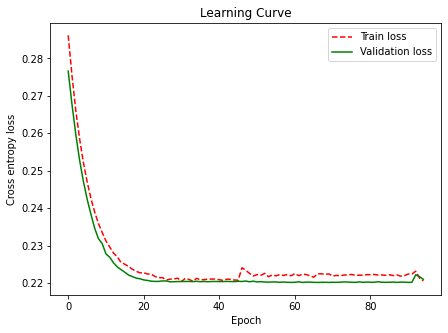


 Test AUC is 0.5001295804977417
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|   GNN1.linear_m_0.weight   |    1800    |
|   GNN1.linear_m_1.weight   |    900     |
|   GNN1.linear_v_0.weight   |    2700    |
|    GNN1.linear_v_0.bias    |     30     |
|   GNN1.linear_v_1.weight   |    900     |
|    GNN1.linear_v_1.bias    |     30     |
|   GNN1.linear_r_0.weight   |    2700    |
|    GNN1.linear_r_0.bias    |     30     |
|   GNN1.linear_r_1.weight   |    900     |

33748

In [ ]:
# Test with a good initial state and without BN before alpha updater

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=3)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.bn = nn.BatchNorm1d(15)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
# Test with a good initial state and without BN before alpha updater

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,15,15,15,15,15,15,15,15,15,1,15,15,num_layers=3)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.bn = nn.BatchNorm1d(15, affine=False)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

RuntimeError: ignored

In [ ]:
# Data Generation 

def bond_is_in_ring_list_one_hot(bond, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [bond.IsInRing()]+[bond.IsInRingSize(i) for i in list]

class CanonicalBondFeaturizer(fs.BaseBondFeaturizer):
       def __init__(self, bond_data_field='e', self_loop=False):
        super(CanonicalBondFeaturizer, self).__init__(
            featurizer_funcs={bond_data_field: fs.ConcatFeaturizer(
                [fs.bond_type_one_hot,
                 fs.bond_is_conjugated,
                 fs.bond_is_in_ring,
                 fs.bond_stereo_one_hot,
                 fs.bond_direction_one_hot,
                 bond_is_in_ring_list_one_hot
                 ]
            )}, self_loop=self_loop)
        
CanonicalBondFeaturizer = CanonicalBondFeaturizer()

# Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)

# Edge_features=[]
# no_edge=[]
# for i in range(Tox21_dataset.smiles.size):
#   try:
#     Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
#   except:
#     no_edge.append(i)
#     Edge_features.append('no_edge')

# Tox21_dataset.drop(no_edge, inplace=True)

# for i in range(len(no_edge)):
#   del Edge_features[no_edge[i]-i]

# %cd /content/

# if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF_NOH.zip'

# global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,1:].values)
# with open('Node_features_AF_NOH.pickle', 'rb') as handle:
#     Node_features = pickle.load(handle)
1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.# for i in range(len(no_edge)):
#   del Node_features[no_edge[i]-i]

# for i in range(len(no_edge)):
#   global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

class DGLDatasetTox(torch.utils.data.Dataset):

    def __init__(self):

        Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)
        
        Edge_features=[]
        no_edge=[]
        for i in range(Tox21_dataset.smiles.size):
          try:
            Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
          except:
            no_edge.append(i)
            Edge_features.append('no_edge')

        Tox21_dataset.drop(no_edge, inplace=True)

        for i in range(len(no_edge)):
          del Edge_features[no_edge[i]-i]

        %cd /content/

        if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip'

        #global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(0).iloc[:,1:].values) # 101 NaN: should be addrressed correctly
        gf_df = pd.read_csv('tox21-global-cdf-rdkit.csv')
        global_fetures = torch.Tensor(gf_df.fillna(gf_df.mean()).iloc[:,1:].values) # 101 NaN; fill mean

        with open('Node_Features_AF3_NOH.pickle', 'rb') as handle:
            Node_features = pickle.load(handle)
        Node_features[1910][1][-3] = 1.1 # problem with the atom
        for i in range(len(no_edge)):
          del Node_features[no_edge[i]-i]

        for i in range(len(no_edge)):
          global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

        self.dgl_graphs = []
        for i in range(len(Node_features)):
          mol = Chem.MolFromSmiles(Tox21_dataset.iloc[i,-1])
          self.dgl_graphs.append(dgllife.utils.mol_to_bigraph(mol, canonical_atom_order=False))
          self.dgl_graphs[i].ndata['h_0'] = Node_features[i]
          self.dgl_graphs[i].edata['e_0'] = Edge_features[i]

        self.smiles = []
        for o in range(len(self.dgl_graphs)):
          self.smiles.append(Tox21_dataset.iloc[o,13])
          
        self.global_fetures = global_fetures
        self.labels = Tox21_dataset.iloc[:,:12].values
        self.masks = Tox21_dataset.replace({0: 1}).iloc[:,:12].values        
        
        # # Unzip the dataset and read its csv file, and fill in NaN values with 0
        # self.csv = pd.read_csv(csv_url, compression='gzip').fillna(0) 

        # # Make masks for labels (0 as NaN value, and 1 as other values)
        # self.masks_csv = pd.read_csv(csv_url, compression='gzip').replace({0: 1}).fillna(0)

        # # Split smiles, labels, and masks columns as lists
        # self.smiles = self.csv.iloc[:,13]
        # self.labels = self.csv.iloc[:,:12].values
        # self.masks = self.masks_csv.iloc[:,:12].values 

    def __len__(self):
        return len(self.dgl_graphs)

    def __getitem__(self, idx):
        return  self.smiles[idx], self.dgl_graphs[idx], self.global_fetures[idx], torch.Tensor(self.labels[idx]), torch.Tensor(self.masks[idx])
        
dataset = DGLDatasetTox()

# Train, validation, and test set split
train_set, val_set, test_set = dgllife.utils.ScaffoldSplitter.train_val_test_split(dataset, frac_val=0.1, frac_test=0.1)

def collate(batch):
    # batch is a list of triples (graphs, labels, masks)
    # Concatenate a sequence of graphs
    
    smiles = [e[0] for e in batch]
    
    graphs = [e[1] for e in batch]
    g = dgl.batch(graphs)

    gf = [e[2] for e in batch]
    gf = torch.stack(gf, 0)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[3] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (masks) along a new dimension
    masks = [e[4] for e in batch]
    masks = torch.stack(masks, 0)

    return smiles, g, gf, labels, masks

def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader

# borrowed form: https://stackoverflow.com/a/62508086
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def my_loss(output, label, mask=None):
    criterion = nn.BCELoss(reduction='none')
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
    return loss 

def train_model(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {epoch_train_loss:.5f} ' +
                     f'valid_loss: {epoch_val_loss:.5f}')
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    ##Learning Curve
    plt.figure(figsize=(7,5))
    plt.figure(figsize=(7,5))
    # Draw lines
    plt.plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    plt.plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Epoch"), plt.ylabel("Cross entropy loss"), plt.legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) 
    print('\n Test AUC is', average.item()/12)

    return  model, train_losses, val_losses 

RDKit WARNING: [15:27:15] WARNING: not removing hydrogen atom without neighbors


/content
Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip
  inflating: tox21-global-cdf-rdkit.csv  
Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip
  inflating: Node_Features_AF3_NOH.pickle  


RDKit WARNING: [15:27:27] WARNING: not removing hydrogen atom without neighbors


Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/7812
Creating RDKit molecule instance 2000/7812


RDKit WARNING: [15:27:36] WARNING: not removing hydrogen atom without neighbors


Creating RDKit molecule instance 3000/7812
Creating RDKit molecule instance 4000/7812
Creating RDKit molecule instance 5000/7812
Creating RDKit molecule instance 6000/7812
Creating RDKit molecule instance 7000/7812
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/7812
Computing Bemis-Murcko for compound 2000/7812
Computing Bemis-Murcko for compound 3000/7812
Computing Bemis-Murcko for compound 4000/7812
Computing Bemis-Murcko for compound 5000/7812
Computing Bemis-Murcko for compound 6000/7812
Computing Bemis-Murcko for compound 7000/7812


In [ ]:
%%capture
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu" 

class GGNN(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_r_dim, rep_dim, rnn_layers, hidden1_alpha_dim, hidden2_alpha_dim, rnn_initial_state='Default', act1="selu", act2="selu", act3="selu", act4="selu", act5="selu", act6='tanh', act7="selu", num_layers=5):
        super().__init__()
        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_r_dim = hidden_r_dim
        self.rep_dim = rep_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        self.rnn_layers = rnn_layers 

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim, self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        
        self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)

        self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_r_dim)
        self.linear_r_1 = nn.Linear(self.hidden_r_dim, self.state_g_dim)

        self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        if rnn_initial_state == 'Default':
        #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
          self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        else:
          self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.batchnorm = nn.BatchNorm1d(1, affine=False)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # It has a depth of 3
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.batchnorm(self.linear_alpha_2(out))
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.linear_r_0(cat))
      out = self.act5(self.linear_r_1(out))

      return {'r' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)
      out=self.act4(self.linear_v_0(cat))
      out=self.act4(self.linear_v_1(out))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.linear_m_0(cat))
      out=self.act3(self.linear_m_1(out))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.linear_e_0(input))
      out=self.act2(self.linear_e_1(out))

      return out

    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.linear_0_g(fg)).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # RNN in Pytorch
      # input of shape (seq_len, batch, input_size) 
      # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # output of shape (seq_len, batch, num_directions * hidden_size)
      # h_n of shape (num_layers * num_directions, batch, hidden_size)
      h_rnn=[]
      h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge and node states
        mol_dgl_graph.edata['e'] = self.act1(self.linear_0_e(mol_dgl_graph.edata["e_0"]))
        mol_dgl_graph.ndata['h'] = self.act1(self.linear_0_v(mol_dgl_graph.ndata["h_0"]))

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[i].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[i].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'r').view(1, len_batch,-1)),0)

          # molecular representation untill this layer
          hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          h_rnn.append(h_rnn_buffer)

          # calculating next layer's alphas
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_rep = torch.empty(0, device=device)
          for j in range(len_batch): 
            global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

        return (hG[-1], h_rnn[-1], alpha) # was hg[-1]

In [ ]:
# Test with a good initial state and without BN before alpha updater

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=3)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.bn = nn.BatchNorm1d(15, affine=False)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 32/200] train_loss: 0.18894 valid_loss: 0.20807
EarlyStopping counter: 3 out of 25


In [ ]:
# code for checking NaNs in node featurs
n=0
for i in range(len(Node_features)):
  if torch.isnan(Node_features[i]).any() == True:
    n +=1
n

In [ ]:
# code for checking NaNs in node featurs
n=0
for i in range(len(Node_features_n)):
  if torch.isnan(Node_features_n[i]).any() == True:
    n +=1
n

In [ ]:
with open('TOX21_Node_features_5AF_OH_Yb-solved.pickle', 'wb') as handle:
    pickle.dump(Node_features, handle)

In [ ]:
     with open('TOX21_Node_features_5AF_OH_Yb-solved.pickle', 'rb') as handle:
            Node_features_n = pickle.load(handle)
        #Node_features[1910][1][-3] = 1.1 # problem with the atom

In [ ]:
!cp TOX21_Node_features_5AF_OH_Yb-solved.zip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/'
!ls '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/'

Node_Features_AF3_NOH.zip	tox21-global-cdf-rdkit.zip
Node_Features_AF3_OH_Plus2.zip	TOX21_Node_features_5AF_OH_Yb-solved.zip
Node_features_AF_NOH.zip


In [ ]:
!zip TOX21_Node_features_5AF_OH_Yb-solved.zip TOX21_Node_features_5AF_OH_Yb-solved.pickle

  adding: TOX21_Node_features_5AF_OH_Yb-solved.pickle (deflated 98%)


In [ ]:
with open('TOX21_Node_features_5AF_OH_Yb-solved.pickle', 'wb') as handle:
    pickle.dump(Node_features, handle)

In [ ]:
     with open('TOX21_Node_features_5AF_OH_Yb-solved.pickle', 'rb') as handle:
            Node_features_n = pickle.load(handle)
        #Node_features[1910][1][-3] = 1.1 # problem with the atom

In [ ]:
!cp TOX21_Node_features_5AF_OH_Yb-solved.zip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/'
!ls '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/'

Node_Features_AF3_NOH.zip	tox21-global-cdf-rdkit.zip
Node_Features_AF3_OH_Plus2.zip	TOX21_Node_features_5AF_OH_Yb-solved.zip
Node_features_AF_NOH.zip


In [ ]:
!zip TOX21_Node_features_5AF_OH_Yb-solved.zip TOX21_Node_features_5AF_OH_Yb-solved.pickle

  adding: TOX21_Node_features_5AF_OH_Yb-solved.pickle (deflated 98%)
